In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt 

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

In [3]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
df_train=df_train.drop(['id'],axis=1)
df_test = df_test.drop(['id'],axis=1)

In [5]:
df_test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [6]:
df_train.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [7]:
df_test.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [8]:
from datetime import datetime
current_year = datetime.now().year
df_train['car_age'] = current_year - df_train['model_year']
df_train['mileage_per_year'] = df_train['milage'] / df_train['car_age'].replace(0, 1)
df_train['accident_clean_interaction'] = df_train.apply(
    lambda x: 'No Accidents & Clean Title' if x['accident'] == 'None reported' and x['clean_title'] == 'Yes' else
              'Accident & Clean Title' if x['accident'] != 'None reported' and x['clean_title'] == 'Yes' else
              'Accident & No Clean Title',
    axis=1
)
df_train['horsepower'] = df_train['engine'].str.extract(r'(\d+\.?\d*)').astype(float)
luxury_brands = ['Mercedes-Benz', 'BMW', 'Genesis', 'Audi', 'Lexus']
df_train['luxury_car'] = df_train['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

In [9]:
df_test['car_age'] = current_year - df_test['model_year']
df_test['mileage_per_year'] = df_test['milage'] / df_test['car_age'].replace(0, 1)
df_test['accident_clean_interaction'] = df_test.apply(
    lambda x: 'No Accidents & Clean Title' if x['accident'] == 'None reported' and x['clean_title'] == 'Yes' else
              'Accident & Clean Title' if x['accident'] != 'None reported' and x['clean_title'] == 'Yes' else
              'Accident & No Clean Title',
    axis=1
)
df_test['horsepower'] = df_test['engine'].str.extract(r'(\d+\.?\d*)').astype(float)
df_test['luxury_car'] = df_test['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

In [10]:
df_train.shape

(188533, 17)

In [11]:
df_train.describe()

,model_year,milage,price,car_age,mileage_per_year,horsepower,luxury_car
count,188533.000000,188533.000000,1.885330e+05,188533.000000,188533.000000,186677.000000,188533.000000
mean,2015.829998,65705.295174,4.387802e+04,8.170002,8696.321414,286.130542,0.300738
std,5.660967,49798.158076,7.881952e+04,5.660967,6272.787877,164.592708,0.458580
min,1974.000000,100.000000,2.000000e+03,0.000000,5.263158,1.200000,0.000000
25%,2013.000000,24115.000000,1.700000e+04,4.000000,5166.666667,204.000000,0.000000
50%,2017.000000,57785.000000,3.082500e+04,7.000000,8000.000000,300.000000,0.000000
75%,2020.000000,95400.000000,4.990000e+04,11.000000,11000.000000,395.000000,1.000000
max,2024.000000,405000.000000,2.954083e+06,50.000000,235000.000000,1020.000000,1.000000


In [12]:
df_train.shape,df_test.shape

((188533, 17), (125690, 16))

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   brand                       188533 non-null  object 
 1   model                       188533 non-null  object 
 2   model_year                  188533 non-null  int64  
 3   milage                      188533 non-null  int64  
 4   fuel_type                   183450 non-null  object 
 5   engine                      188533 non-null  object 
 6   transmission                188533 non-null  object 
 7   ext_col                     188533 non-null  object 
 8   int_col                     188533 non-null  object 
 9   accident                    186081 non-null  object 
 10  clean_title                 167114 non-null  object 
 11  price                       188533 non-null  int64  
 12  car_age                     188533 non-null  int64  
 13  mileage_per_ye

In [14]:
df_train.drop(columns=['model_year', 'accident', 'clean_title', 'engine'], inplace=True)
df_test.drop(columns=['model_year', 'accident', 'clean_title', 'engine'], inplace=True)

In [15]:
df_train.shape,df_test.shape

((188533, 13), (125690, 12))

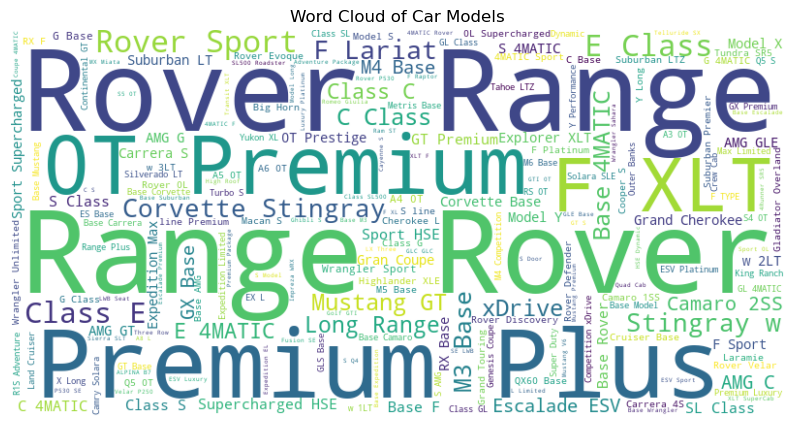

In [16]:
from wordcloud import WordCloud

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(df_train['model']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Car Models')
plt.show()


In [16]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


def preprocess_and_encode(df_train, df_test): 
    cat_cols = df_train.select_dtypes(include=['object']).columns
    num_cols = df_train.select_dtypes(include=['number']).columns
    num_cols = num_cols[num_cols != 'price']     
    cat_imputer = SimpleImputer(strategy='most_frequent')
    num_imputer = SimpleImputer(strategy='median')
    df_train[cat_cols] = cat_imputer.fit_transform(df_train[cat_cols])
    df_test[cat_cols] = cat_imputer.transform(df_test[cat_cols])
    df_train[num_cols] = num_imputer.fit_transform(df_train[num_cols])
    df_test[num_cols] = num_imputer.transform(df_test[num_cols])
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df_train[cat_cols] = ordinal_encoder.fit_transform(df_train[cat_cols].astype(str))
    df_test[cat_cols] = ordinal_encoder.transform(df_test[cat_cols].astype(str))    
    return df_train, df_test
df_train, df_test = preprocess_and_encode(df_train, df_test)

In [19]:
y = df_train['price'].astype('float32')
df_train = df_train.drop(['price'],axis=1)

In [20]:
y

0          4200.0
1          4999.0
2         13900.0
3         45000.0
4         97500.0
           ...   
188528    27500.0
188529    30000.0
188530    86900.0
188531    84900.0
188532    28995.0
Name: price, Length: 188533, dtype: float32

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Scale_train = scaler.fit_transform(df_train)
Scale_test  = scaler.transform(df_test)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(Scale_train, y,test_size=0.2)

In [36]:
tf.keras.activations.gelu
tf.keras.activations.selu
tf.keras.activations.elu

model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation="gelu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear')
])


In [37]:
early_stopping = callbacks.EarlyStopping(monitor="val_loss",patience=15,restore_best_weights=True)


In [38]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1 ,patience=5,min_lr=0.001)


In [39]:
from tensorflow.keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(
    loss='mean_squared_error',  
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.009),
    metrics=[rmse]  
)

In [40]:
neural = model.fit(X_train,y_train,epochs=20,callbacks=[early_stopping,reduce_lr],validation_data=(X_test, y_test))

Epoch 1/20
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 5339880960.0000 - rmse: 46541.3242 - val_loss: 6346739200.0000 - val_rmse: 46809.4570 - learning_rate: 0.0090
Epoch 2/20
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5026499072.0000 - rmse: 45118.3281 - val_loss: 6337858048.0000 - val_rmse: 47822.3594 - learning_rate: 0.0090
Epoch 3/20
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5182426624.0000 - rmse: 45747.2148 - val_loss: 6486208512.0000 - val_rmse: 47201.4805 - learning_rate: 0.0090
Epoch 4/20
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5544295936.0000 - rmse: 46607.1562 - val_loss: 6552496640.0000 - val_rmse: 47927.7344 - learning_rate: 0.0090
Epoch 5/20
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5036050432.0000 - rmse: 45039.1719 - val_loss: 6545088512.0000 - val_rmse: 47962.8906 - learning_rate: 0.0090
Epoch 6/20
4714/4714 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 5594731008.0000 - rmse: 46184.9453 - val_loss: 6723772928.0000 - val_rms

<Axes: >

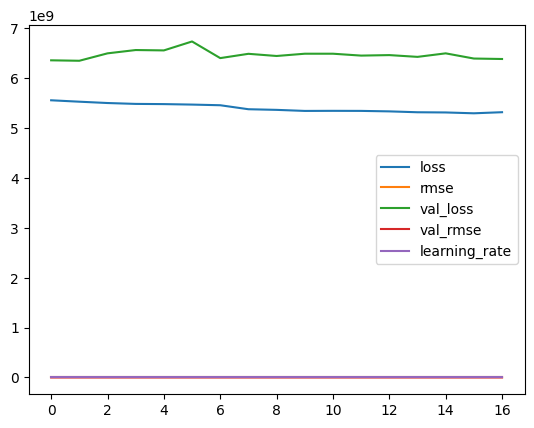

In [41]:

pd.DataFrame(neural.history).plot()

In [42]:
finalpred= model.predict(Scale_test)


3928/3928 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [43]:
finalpred

array([[19722.59 ],
       [70810.68 ],
       [56956.35 ],
       ...,
       [23599.26 ],
       [16276.124],
       [30911.254]], dtype=float32)

In [44]:
df_sub['price']=finalpred

In [45]:
df_sub['price'] = df_sub['price']

In [46]:
df_sub.to_csv('submission.csv', index=False)

<Axes: >

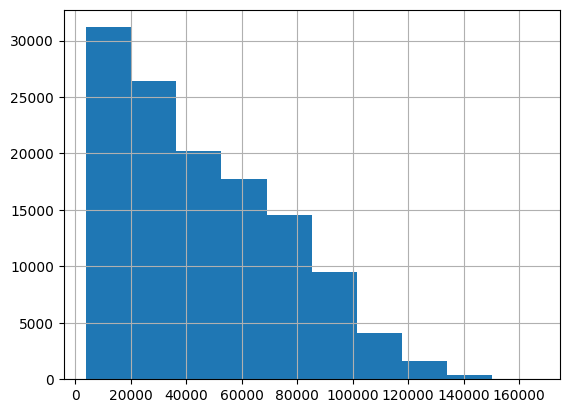

In [47]:
df_sub['price'].hist()

In [48]:
df_sub

,id,price
0,188533,19722.589844
1,188534,70810.679688
2,188535,56956.351562
3,188536,32353.160156
4,188537,35617.968750
...,...,...
125685,314218,28330.896484
125686,314219,55748.203125
125687,314220,23599.259766
125688,314221,16276.124023
